# PCA on 8 upper atm variables, followed by kmeans

Datails.... 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [43]:
from IPython import display
import numpy as np
import torch
from torch import nn
mse = nn.MSELoss()

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

### Load model output data

In [3]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [4]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [5]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# PCA on 1st variable

In [6]:
load_uatm_erai()

Days loaded 13515


In [7]:
#A = torch.ones(2,2,2,3)
#A = torch.tensor(np.array(mdv1[0:1]))
A = torch.tensor(np.array(mdv1)).flatten(1)
A.shape

torch.Size([13515, 324])

In [9]:
# PCA
U, S, V = torch.pca_lowrank(A)

In [10]:
print(U.shape)
print(S.shape)
print(V.shape)

torch.Size([13515, 6])
torch.Size([6])
torch.Size([324, 6])


In [11]:
torch.transpose(V, 0, 1).shape

torch.Size([6, 324])

In [12]:
# approximate original, AA = USV
print(U.shape)
print(S.shape)
print(V.shape)
SV = torch.matmul(torch.diag(S) , torch.transpose(V, 0, 1) )
SV.shape
AA = torch.matmul(U , SV)
print(AA.shape)

torch.Size([13515, 6])
torch.Size([6])
torch.Size([324, 6])
torch.Size([13515, 324])


torch.Size([324])


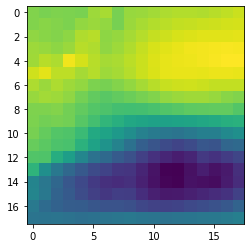

In [13]:
# 1st primary component 
U1 = U[0]*0 
U1[0] = 1
U1

# graph 1st component
AA = torch.matmul(U1 , SV)
print(AA.shape)
plt.imshow(AA.view(18,18))

tensor([1., -0., -0., -0., -0., 0.])
torch.Size([324])


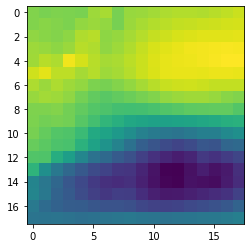

tensor([0., 1., -0., -0., -0., 0.])
torch.Size([324])


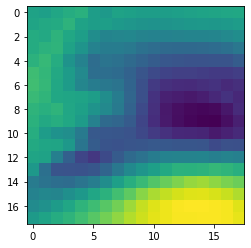

tensor([0., -0., 1., -0., -0., 0.])
torch.Size([324])


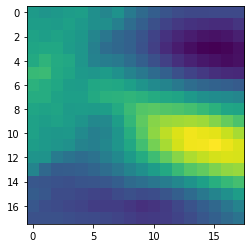

tensor([0., -0., -0., 1., -0., 0.])
torch.Size([324])


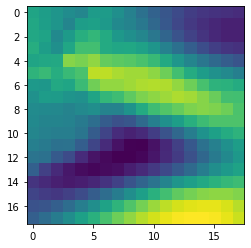

tensor([0., -0., -0., -0., 1., 0.])
torch.Size([324])


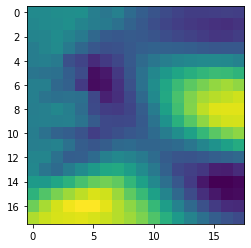

tensor([0., -0., -0., -0., -0., 1.])
torch.Size([324])


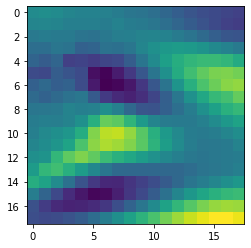

In [14]:
# show all 6 components
for ii in range(6):
    UU = U[0]*0 
    UU[ii] = 1
    print(UU)

    # graph 1st component
    AA = torch.matmul(UU , SV)
    print(AA.shape)
    plt.imshow(AA.view(18,18))
    plt.show()

### Let's reproduce each day of  1st variable (U850) from just 6 numbers!

In [15]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature


Reconstruct vs actual (U850)
0 tensor([ 0.0036, -0.0013, -0.0123, -0.0050, -0.0269,  0.0039])


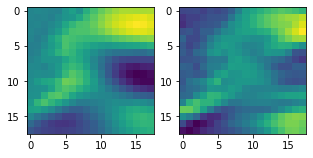

1 tensor([ 0.0104, -0.0035, -0.0013,  0.0014, -0.0074,  0.0037])


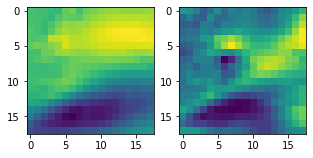

2 tensor([ 0.0049,  0.0043, -0.0085,  0.0024,  0.0036,  0.0124])


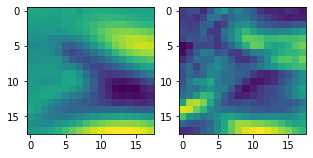

3 tensor([ 0.0066,  0.0015, -0.0100, -0.0044, -0.0222,  0.0104])


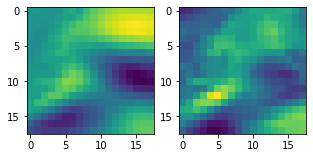

4 tensor([ 0.0124, -0.0025, -0.0111, -0.0033, -0.0181,  0.0039])


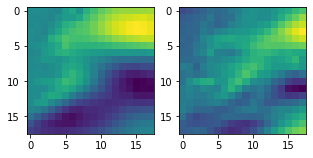

5 tensor([ 0.0119, -0.0094,  0.0018,  0.0007, -0.0252,  0.0066])


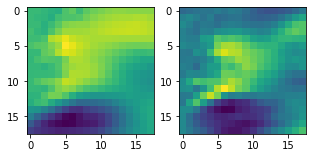

6 tensor([ 0.0070, -0.0275,  0.0084, -0.0038,  0.0078,  0.0096])


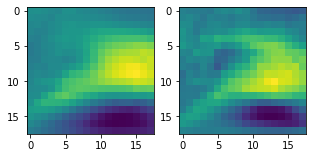

7 tensor([-0.0063, -0.0112, -0.0014,  0.0062,  0.0003,  0.0011])


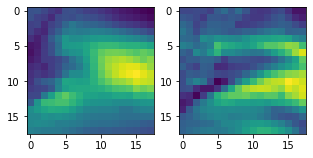

8 tensor([-0.0108, -0.0025, -0.0049,  0.0125, -0.0099, -0.0010])


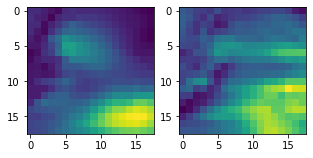

9 tensor([ 0.0001, -0.0041,  0.0110,  0.0140, -0.0222,  0.0055])


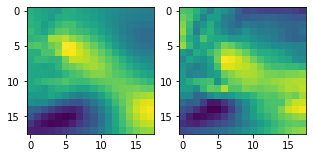

10 tensor([-0.0004, -0.0282,  0.0173, -0.0078, -0.0204,  0.0019])


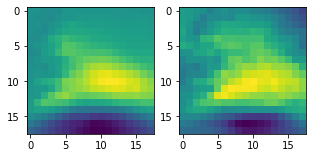

11 tensor([-0.0071, -0.0096,  0.0128, -0.0053, -0.0104,  0.0136])


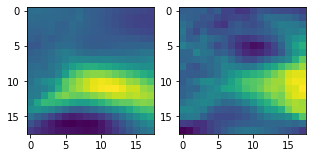

12 tensor([-0.0134, -0.0077,  0.0008, -0.0038, -0.0215, -0.0132])


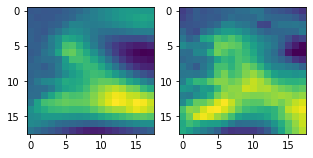

13 tensor([-5.7745e-03, -1.7172e-05, -7.2427e-03,  8.9045e-03, -1.3553e-02,
         7.2744e-04])


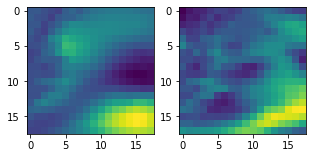

14 tensor([ 0.0050,  0.0023, -0.0022, -0.0021, -0.0140, -0.0148])


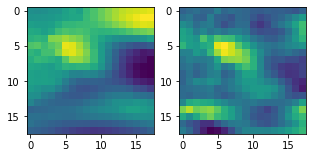

15 tensor([ 0.0025, -0.0004, -0.0039,  0.0066,  0.0021, -0.0238])


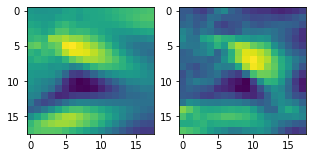

16 tensor([ 0.0052, -0.0066, -0.0003,  0.0055,  0.0081, -0.0002])


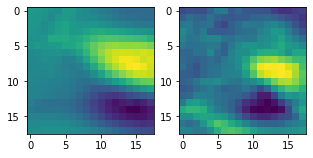

17 tensor([ 0.0040, -0.0059,  0.0004, -0.0046,  0.0066, -0.0087])


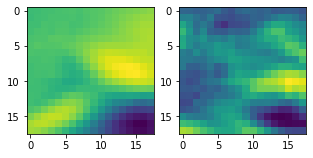

18 tensor([-0.0080,  0.0024, -0.0011,  0.0019,  0.0115, -0.0198])


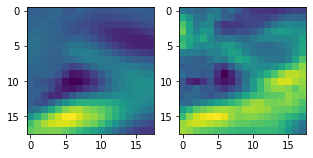

19 tensor([-0.0115,  0.0022, -0.0018, -0.0005,  0.0131,  0.0055])


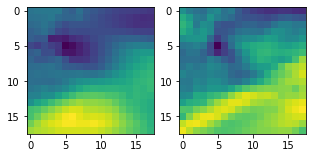

In [16]:
AA = torch.matmul(U , SV)
print("Reconstruct vs actual (U850)")
for ii in range(20):
    print(ii, U[ii])
    #fig, axarr = plt.subplots(1, 2, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    fig, axarr = plt.subplots(1, 2, figsize = (5,5))
    
    #axarr[ii].coastlines()
    #axarr[ii].add_feature(cfeature.STATES)
    #img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
    plot = axarr[0].imshow(AA[ii].view(18,18))  
    plot = axarr[1].imshow(A[ii].view(18,18))  
    plt.show()

### Kmeans

In [17]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
import scipy.cluster

In [18]:
scipy.cluster.vq.kmeans(U, 6)

(array([[ 0.00022903, -0.00224032,  0.00107831,  0.01378713, -0.00069693,
         -0.00337727],
        [-0.00065965, -0.00658548, -0.01013909, -0.00275152, -0.00503722,
          0.00090889],
        [ 0.00595172, -0.00478887,  0.00181771, -0.00322331,  0.00836918,
          0.00230211],
        [-0.00372661,  0.00064107,  0.00442929, -0.00438529, -0.00045272,
         -0.00969202],
        [-0.00308387,  0.00811572, -0.00301188, -0.00026651,  0.00375572,
          0.00309166],
        [ 0.00260522,  0.00218046,  0.00707454, -0.00092173, -0.00847379,
          0.00661575]], dtype=float32),
 0.016082097)

#### GRAPH

In [21]:
# PCA: reduce to 2 dimensions
reduced_data, trash, trash = torch.pca_lowrank(U, 2)

In [22]:
reduced_data

tensor([[ 0.0075, -0.0215],
        [-0.0014, -0.0134],
        [ 0.0047, -0.0054],
        ...,
        [-0.0044, -0.0010],
        [-0.0117, -0.0036],
        [-0.0081,  0.0006]])

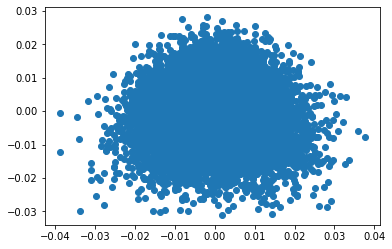

In [26]:
plt.scatter(reduced_data[:,0], reduced_data[:,1])

In [141]:
centroids, trash = scipy.cluster.vq.kmeans(reduced_data, 6)

In [142]:
centroids.shape

(6, 2)

In [68]:
centroids[1], reduced_data[0]

(array([0.00119121, 0.01146613], dtype=float32), tensor([ 0.0075, -0.0215]))

In [115]:
def predict_label(centroids, reduced_data):
    # find closest centroid
    best_label = 0
    label = 0
    label_distance = 9999.
    for centroid in torch.tensor(centroids):
        distance =  mse(centroid, reduced_data)
        #ditance = centroid+reduced_data
        if distance < label_distance:
            best_label = label
            label_distance = distance
        label += 1
    return best_label
    

In [116]:
torch.tensor([-0.0093348 , -0.00981239])

tensor([-0.0093, -0.0098])

In [138]:
#Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
xxyy = torch.tensor(list(zip(xx.ravel(), yy.ravel())))

In [149]:
predict_label(centroids, xxyy[0])

5

In [163]:
#[predict_label(centroids, data) for data in xxyy]

In [27]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

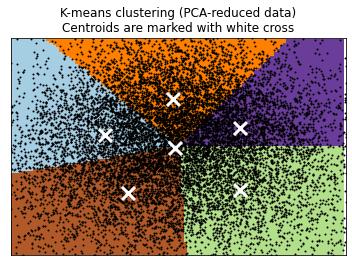

In [162]:
# Obtain labels for each point in mesh. Use last trained model.
#Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array([predict_label(centroids, data) for data in xxyy])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")


plt.plot(reduced_data[:, 0]*60, reduced_data[:, 1]*60, 'k.', markersize=2)
plt.scatter(centroids[:, 0]*40, centroids[:, 1]*40, marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [154]:
centroids

array([[-0.01131719,  0.00278408],
       [ 0.00961819, -0.01027991],
       [-0.0005705 , -0.00048978],
       [-0.00085656,  0.01129225],
       [ 0.00952592,  0.00431893],
       [-0.00780126, -0.01105616]], dtype=float32)

## Add rain dimension

In [165]:
scipy.cluster.vq.kmeans(U, 6)

(array([[ 0.00263053,  0.00391676,  0.00628298, -0.00186545, -0.00853564,
          0.00562181],
        [ 0.00105599, -0.00193398,  0.00144796,  0.013971  , -0.0012385 ,
         -0.00374254],
        [-0.00240518, -0.00761812, -0.00888514, -0.00184267, -0.0036511 ,
          0.00324823],
        [ 0.00797089, -0.00467538,  0.00306875, -0.00415226,  0.00655702,
         -0.00044741],
        [-0.00221871,  0.00704014, -0.00281701,  0.00040912,  0.00587978,
          0.00396933],
        [-0.00540215,  0.00138799,  0.00266889, -0.00400685, -0.00102091,
         -0.00958905]], dtype=float32),
 0.016046181)

In [169]:
sigfile = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc'
rainsignal = xr.open_dataset(sigfile)['prec']
rainsignal.shape

(9497, 1, 1)

In [198]:
float(rainsignal[0])
rst = torch.tensor([float(rs) for rs in rainsignal])
rst.view(9497,1).shape

torch.Size([9497, 1])

In [195]:
U[0:9497].shape

torch.Size([9497, 6])

In [201]:
sevend = torch.cat([U[0:9497], rst.view(9497,1)], dim=1)
sevend.shape

torch.Size([9497, 7])

In [202]:
scipy.cluster.vq.kmeans(sevend, 6)

(array([[-3.7070457e-04, -8.7336201e-04, -7.1496551e-04, -2.6504739e-04,
         -5.3933827e-04,  6.1847211e-05,  5.0506156e-02],
        [ 1.1807836e-04,  3.9232299e-03,  2.5372112e-03,  1.4416081e-03,
          2.9944361e-03, -7.2930806e-04,  2.3140503e+01],
        [ 1.2695106e-03,  2.6564691e-03,  1.8626177e-03,  1.9958112e-03,
          1.5310397e-03, -5.0457910e-04,  5.1201921e+00],
        [ 1.0001453e-03,  2.2277397e-03,  1.2752656e-03,  1.2254512e-03,
          8.7864400e-04, -8.5603801e-04,  1.7376924e+00],
        [ 1.1256803e-03,  5.3890981e-03,  4.2215739e-03,  1.1445674e-03,
          4.2692721e-03, -6.2062294e-04,  4.6913059e+01],
        [ 1.3623066e-03,  3.3337697e-03,  2.4955559e-03,  1.5425781e-03,
          1.3237232e-03, -1.0764849e-03,  1.1559826e+01]], dtype=float32),
 0.5179364)

# PCA on all 8 variables

In [203]:
#mdv1.sel(time=ot,method='nearest')
isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]


NameError: name 'ot' is not defined